In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Lendo os arquivos de resultados e fazendo castings

In [2]:
resultados =  pd.read_csv('../outputs_nostemmer/Resultados.csv', sep=';')
resultados_stemmer = pd.read_csv('../outputs_stemmer/Resultados.csv', sep=';')

In [3]:
resultados[['Rank', 'DocNumber', 'Score']] = resultados['List'].str.strip('[]').str.split(', ', expand=True)
resultados['QueryNumber'] = resultados['QueryNumber'].astype(int)
resultados['Rank'] = resultados['Rank'].astype(int)
resultados['DocNumber'] = resultados['DocNumber'].astype(int)
resultados['Score'] = resultados['Score'].astype(float)

In [4]:
resultados.columns

Index(['QueryNumber', 'List', 'Rank', 'DocNumber', 'Score'], dtype='object')

In [5]:
resultados_stemmer[['Rank', 'DocNumber', 'Score']] = resultados_stemmer['List'].str.strip('[]').str.split(', ', expand=True)
resultados_stemmer['Rank'] = resultados_stemmer['Rank'].astype(int)
resultados_stemmer['DocNumber'] = resultados_stemmer['DocNumber'].astype(int)
resultados_stemmer['Score'] = resultados_stemmer['Score'].astype(float)

In [6]:
esperados = pd.read_csv('../outputs_nostemmer/Esperados.csv', sep=';')
esperados['QueryNumber'] = esperados['QueryNumber'].astype(int)
esperados['DocNumber'] = esperados['DocNumber'].astype(int)
esperados['DocVotes'] = esperados['DocVotes'].astype(int)

Durante o processamento identifiquei alguns documentos sem abstract nem extract, como eles não podem ser indexados, não é razoável que eles façam parte dos valores esperados

In [7]:
def teste(resultados, esperados):
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    faltantes = set()
    
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        
        # Encontrar documentos esperados que não estão nos resultados
        documentos_faltantes = set(esperados_busca).difference(set(resultados_busca))
        
        # Adicionar documentos faltantes ao conjunto
        faltantes.update(documentos_faltantes)
    
    # Imprimir os documentos faltantes
    print(f"Documentos faltantes: {faltantes}")
    return faltantes

In [8]:
valores_remover = teste(resultados, esperados)

Documentos faltantes: {512, 128, 1154, 1089, 132, 839, 712, 1225, 329, 894, 595, 729, 735, 1187, 36, 932, 551, 168, 298, 939, 1069, 493, 1150, 1023}


In [9]:
esperados.shape

(4820, 3)

In [10]:
esperados = esperados[~esperados['DocNumber'].isin(valores_remover)]

In [11]:
esperados.shape

(4710, 3)

# Gráfico de 11 pontos de precisão e recall

Para calcular precision e recall precisamos antes definir os valores para os verdadeiros positivos, falso positivo e falso negativo.
* Podemos definir o somatório de VP +FP como tudo aquilo que foi buscado pelo modelo, portanto Precisão = VP/Buscado
* Já VP + Fn pode ser difinido como o conjunto de resultados esperados, portanto Recall = VP/Esperado
* Por fim, VP isoladamente pode ser dado como a interseçao entre o esperado e o obtido VP = Buscado intersec Esperado

Calcularemos 11 pontos de precision e recall para cada query e em seguida faremos a média dos valores

In [27]:
esperados = esperados[esperados['QueryNumber'] != 92]

In [29]:
def curva_precision_recall_11(resultados, esperados, stemmer):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        precisoes = []
        recalls = []
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        dicionario_recall = {}
        for pos, buscas in enumerate(resultados_busca):
            
            buscados_ate_agora = resultados_busca[:pos+1]
            vp = len(set(esperados_busca).intersection(buscados_ate_agora))
            recall = vp/len(esperados_busca)
            precision = vp/len(buscados_ate_agora)
            recall_round = round(recall, 2)
            if recall_round in dicionario_recall.keys():
                dicionario_recall[recall_round] = max(dicionario_recall[recall_round], precision)
            else:
                dicionario_recall[recall_round] = precision
            
            if recall == 1:
                break
        for valor in [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]:
            if valor not in dicionario_recall:
                disponiveis = sorted(dicionario_recall.keys())
                for disponivel in disponiveis:
                    if disponivel >= valor:
                        dicionario_recall[valor] = dicionario_recall[disponivel]
                        break
            recalls.append(valor)
            precisoes.append(dicionario_recall[valor])            
        
        buscas_recall.append(recalls)
        busca_precisions.append(precisoes)
    
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    
    if stemmer:
        figure_path = '../avalia/11_precisao_recall_stemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_stemmer.csv'
    else:
        figure_path = '../avalia/11_precisao_recall_nostemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_nostemmer.csv'
    
    # Plotar o gráfico Precision-Recall
    plt.plot(media_recall, media_precision, marker='o', label='Precision-Recall Curve')

    # Configurações do gráfico
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(figure_path)
    # Exibir o gráfico
    plt.show()
    precision_recall_df = pd.DataFrame(np.array([media_precision, media_recall]).T, columns=["Precision", "Recall"])
    precision_recall_df.to_csv(csv_path, sep=";", index=False)

A Query number 92 tem um comportamento quase paranormal, chega um momento que vp para de incrementar mesmo tendo encontrado todos os documentos relevantes, perdi boas horas nesse problema e não consegui, portanto optei por remover a busca. No trecho abaixo temos quais documentos faltam ser descobertos na busca, a medida que eles aparecem VP fica estagnado em 115, memso havendo crescimento no buscados_ate_agora, o conjunto fica vazio indicando que todos os documentos esperados foram buscados, e mesmo assim o recall continuava em 0.94.

In [ ]:
"""
{1217, 1186, 1219, 1221, 1193, 1194, 1196, 1228, 1229, 1230, 1231, 1235, 1236, 1208}
0.9426229508196722
1202
115 122
{1217, 1219, 1221, 1193, 1194, 1196, 1228, 1229, 1230, 1231, 1235, 1236, 1208}
0.9426229508196722
1203
115 122
{1217, 1219, 1221, 1194, 1196, 1228, 1229, 1230, 1231, 1235, 1236, 1208}
0.9426229508196722
1204
115 122
{1217, 1219, 1221, 1196, 1228, 1229, 1230, 1231, 1235, 1236, 1208}
0.9426229508196722
1205
115 122
{1217, 1219, 1221, 1228, 1229, 1230, 1231, 1235, 1236, 1208}
0.9426229508196722
1206
115 122
{1217, 1219, 1221, 1228, 1229, 1230, 1231, 1235, 1236}
0.9426229508196722
1207
115 122
{1219, 1221, 1228, 1229, 1230, 1231, 1235, 1236}
0.9426229508196722
1208
115 122
{1221, 1228, 1229, 1230, 1231, 1235, 1236}
0.9426229508196722
1209
115 122
{1228, 1229, 1230, 1231, 1235, 1236}
0.9426229508196722
1210
115 122
{1229, 1230, 1231, 1235, 1236}
0.9426229508196722
1211
115 122
{1235, 1236, 1230, 1231}
0.9426229508196722
1212
115 122
{1235, 1236, 1231}
0.9426229508196722
1213
115 122
{1235, 1236}
0.9426229508196722
1214
115 122
{1236}
0.9426229508196722
1215
115 122
set()
"""

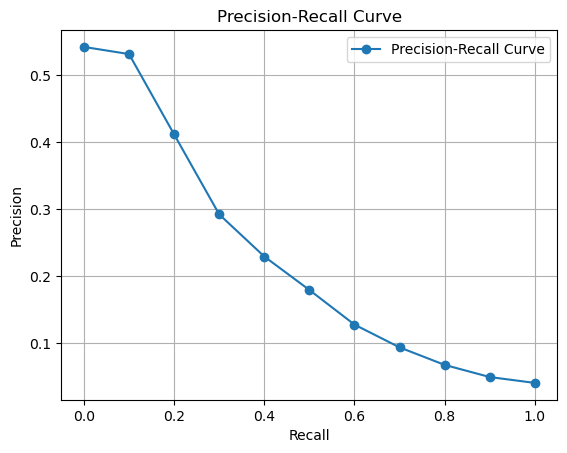

In [32]:
curva_precision_recall_11(resultados_stemmer, esperados, True)

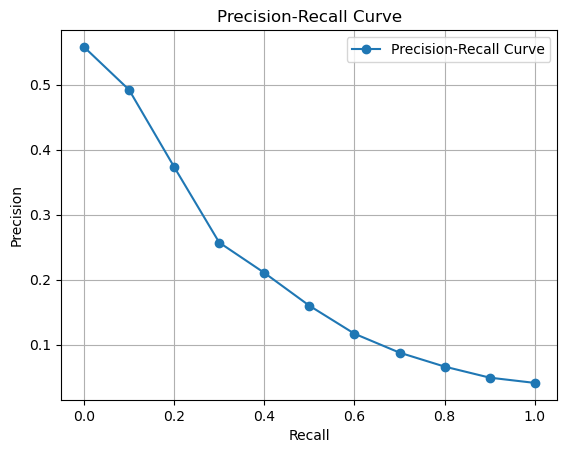

In [33]:
curva_precision_recall_11(resultados, esperados, False)

# F1 

In [34]:
def calculo_f1_score(resultados, esperados):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        recall = []
        precision = []
        vp = len(set(esperados_busca).intersection(resultados_busca))
        precision.append(vp/len(resultados_busca))
        recall.append(vp/len(esperados_busca))
        buscas_recall.append(recall)
        busca_precisions.append(precision)
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    f1 = (2 * media_precision * media_recall)/(media_precision + media_recall)
    return f1

In [35]:
calculo_f1_score(resultados_stemmer, esperados)

array([0.07420466])

In [36]:
calculo_f1_score(resultados, esperados)

array([0.07420466])

# Precision@K

In [37]:
def precisionK(resultados, esperados, k):
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:k]
        relevantes_buscados = len(set(esperados_busca).intersection(resultados_busca))
        precision_k = relevantes_buscados/k
        busca_precisions.append(precision_k)
    mean_precisions = np.mean(np.array(busca_precisions))
    return mean_precisions

Stemmer

In [38]:
#Precision 5
precisionK(resultados_stemmer, esperados, 5)

0.46326530612244904

In [39]:
#Precision 10
precisionK(resultados_stemmer, esperados, 10)

0.39693877551020407

No-Stemmer

In [40]:
#Precision 5
precisionK(resultados, esperados, 5)

0.42448979591836744

In [41]:
#Precision 10
precisionK(resultados, esperados, 10)

0.3581632653061224

# Histograma R Precision comparativo

In [42]:
#Vamos considerar os 10 primeiros valores
#Fazendo o comparativo usando (Stemmer - NoStemmer)
def Histograma_R_Precision(resultados,resultados_stemmer, esperados):
    busca_precisions = []
    busca_precisions_stemmer = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:10]
        resultados_stemmer_busca = resultados_stemmer.loc[resultados_stemmer['QueryNumber'] == busca, 'DocNumber'].to_list()[:10]
        relevantes_buscados = len(set(esperados_busca).intersection(resultados_busca))
        relevantes_buscados_stemmer = len(set(esperados_busca).intersection(resultados_stemmer_busca))
        precision_k = relevantes_buscados/10
        precision_k_stemmer = relevantes_buscados_stemmer/10
        busca_precisions.append(precision_k)
        busca_precisions_stemmer.append(precision_k_stemmer)
    
    comparativo = np.array(busca_precisions) - np.array(busca_precisions_stemmer)
    figure_path = '../avalia/Histograma_R_Precision.pdf'
    csv_path = '../avalia/Histograma_R_Precision.csv'

    R_precision_histogram = pd.DataFrame(np.array([comparativo, list(conjunto_buscas)]).T, columns=["Comparativo", "Buscas"])
    R_precision_histogram.to_csv(csv_path, sep=";", index=False)

    plt.bar(list(conjunto_buscas),comparativo)
    plt.title("Histograma R-Precision comparativo")
    plt.xlabel("Busca")
    plt.ylabel("R-Precision comparativa")
    plt.savefig(figure_path)
    plt.show()

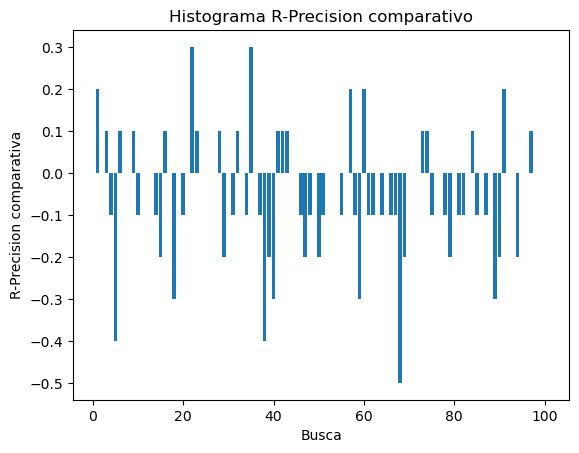

In [43]:
Histograma_R_Precision(resultados,resultados_stemmer, esperados)

# MAP

In [44]:
def MAP(resultados, esperados):
    buscas_precisions_medias = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        precisions = []
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        for pos, buscas in enumerate(resultados_busca):
            buscados_ate_agora = resultados_busca[:pos+1]
            if buscas in esperados_busca:
                relevantes = len(set(esperados_busca).intersection(buscados_ate_agora))
                precision = relevantes/len(buscados_ate_agora)
                precisions.append(precision)
        media = np.mean(np.array(precisions))
        buscas_precisions_medias.append(media)
    return np.mean(np.array(buscas_precisions_medias))

In [45]:
# Sem stemmer
MAP(resultados, esperados)

0.21373297216558104

In [46]:
#Stemmer
MAP(resultados_stemmer, esperados)

0.23132563093312833

In [47]:
def MRR(resultados, esperados):
    ranks = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        rank = 0
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        for pos, buscas in enumerate(resultados_busca):
            if buscas in esperados_busca:
                rank = 1/(pos + 1)
                break
        ranks.append(rank)
    return np.mean(np.array(ranks))

In [48]:
# Sem stemmer
MRR(resultados, esperados)

0.6943898835480469

In [49]:
#Stemmer
MRR(resultados_stemmer, esperados)

0.7011624996318874

# DCG

In [60]:
def DCG(resultados, esperados):
    dcg_tot = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        dcg_busca = []
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:10] # Como é necessário dividir pelo tamanho dos resultados, vou tomar os 10 primeiros
        for pos, buscas in enumerate(resultados_busca):
            ganho_proprio = 0
            if buscas in esperados_busca:
                ganho_proprio = esperados.loc[(esperados['DocNumber'] == buscas) & (esperados['QueryNumber'] == busca),'DocVotes'].values[0]
            if pos == 0:
                dcg_busca.append(ganho_proprio)
            else:
                resultado = dcg_busca[pos-1] + ganho_proprio/np.log2(pos+2)
                dcg_busca.append(resultado)
        media_busca = np.mean(np.array(dcg_busca))
        dcg_tot.append(media_busca)
    return np.mean(np.array(dcg_tot))

In [61]:
# Sem stemmer
DCG(resultados, esperados)

4.144891152813444

In [62]:
#Stemmer
DCG(resultados_stemmer, esperados)

4.356381875970219

# Normalized DCG

In [66]:
def nDCG(resultados, esperados):
    ndcg_tot = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        dcg_busca = []
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()[:10] # Considerando os 10 primeiros resultados
        for pos, buscas in enumerate(resultados_busca):
            ganho_proprio = 0
            if buscas in esperados_busca:
                ganho_proprio = esperados.loc[(esperados['DocNumber'] == buscas) & (esperados['QueryNumber'] == busca), 'DocVotes'].values[0]
            if pos == 0:
                dcg_busca.append(ganho_proprio)
            else:
                resultado = dcg_busca[pos-1] + ganho_proprio/np.log2(pos+2)
                dcg_busca.append(resultado)
        dcg_valor = np.sum(np.array(dcg_busca))

        # Calcular iDCG
        esperados_ordenados = esperados.loc[esperados['QueryNumber'] == busca].sort_values(by='DocVotes', ascending=False)
        idcg_busca = []
        for pos, (_, row) in enumerate(esperados_ordenados.iterrows()):
            if pos >= 10:
                break
            ganho_proprio = row['DocVotes']
            if pos == 0:
                idcg_busca.append(ganho_proprio)
            else:
                resultado = idcg_busca[pos-1] + ganho_proprio/np.log2(pos+2)
                idcg_busca.append(resultado)
        idcg_valor = np.sum(np.array(idcg_busca))

        # Calcular nDCG
        if idcg_valor > 0:
            ndcg_busca = dcg_valor / idcg_valor
        else:
            ndcg_busca = 0

        ndcg_tot.append(ndcg_busca)
    
    return np.mean(np.array(ndcg_tot))

In [67]:
# Sem stemmer
nDCG(resultados, esperados)

0.4340470416728552

In [69]:
#Stemmer
nDCG(resultados_stemmer, esperados)

0.4534414483897526